In [1]:
import pandas as pd
import os
import numpy as np
import signatureanalyzer as sa

/home/sanand/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


---
# Extracting Mutational Signatures

Extracts mutational signatures derived from WES samples in [Bustoros et al (2020)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7367550/) and compares them to SMM subtypes.

For details on how to extract mutational sigantures, please see https://github.com/getzlab/getzlab-SignatureAnalyzer.

**Author**: [Shankara Anand](sanand@broadinstitute.org)

In [6]:
DATA_DIR = "../data/raw"
NMF_FILE = os.path.join(DATA_DIR, "SMM_signatureanalyzer.h5")

In [7]:
samples_df = pd.read_csv(os.path.join(DATA_DIR, "SMM_dbgap_paths.tsv"), sep='\t')
clust_df = pd.read_csv(os.path.join("../Fig1/supplement", "table4_sample_cluster_id.tsv"), sep='\t', index_col=0)

In [9]:
Hraw = pd.read_hdf(NMF_FILE, "Hraw")
Hraw = Hraw.join(samples_df.set_index("fc_tumor")['id']).dropna(subset=['id']).set_index("id")
Wraw = pd.read_hdf(NMF_FILE, "Wraw").iloc[:,:-1]

# Renormalize
W_weight = np.sum(Wraw, axis=0)
W = Wraw / W_weight
H = W_weight[:, np.newaxis]*Hraw.T
H = H.T
H = H.join(clust_df['consensus_nmf'])

# Rename
hd = {
    "SBS12":"SBS5",
    "SBS6":"SBS1",
    "SBS13":"SBS13",
    "SBS2":"SBS85",
    "SBS42":"SBS2",
    "SBS41":"SBS84"
}

# Mapping Appropriate Signatures
H.columns = [x.split("-")[-1] for x in H.columns]
H = H.rename(columns=hd)

hd = {
    "SBS5":"Aging-5",
    "SBS1":"Aging-1",
    "SBS13":"APOBEC activity-13",
    "SBS85":"AID-85",
    "SBS2":"APOBEC activity-2",
    "SBS84":"AID-84"
}

H = H.rename(columns=hd)
H['APOBEC activity-2_13'] = H['APOBEC activity-13'] + H['APOBEC activity-2']
H['Aging-1_5'] = H['Aging-1'] + H['Aging-5']
H['AID-84_85'] = H['AID-84'] + H['AID-85']
H.to_csv("supplement/table8_mut_sigs.tsv", sep='\t')

In [11]:
H = pd.read_hdf(NMF_FILE, "H")
H = H.join(samples_df.set_index("fc_tumor")['id']).dropna(subset=['id']).set_index("id")
W = pd.read_hdf(NMF_FILE, "W")

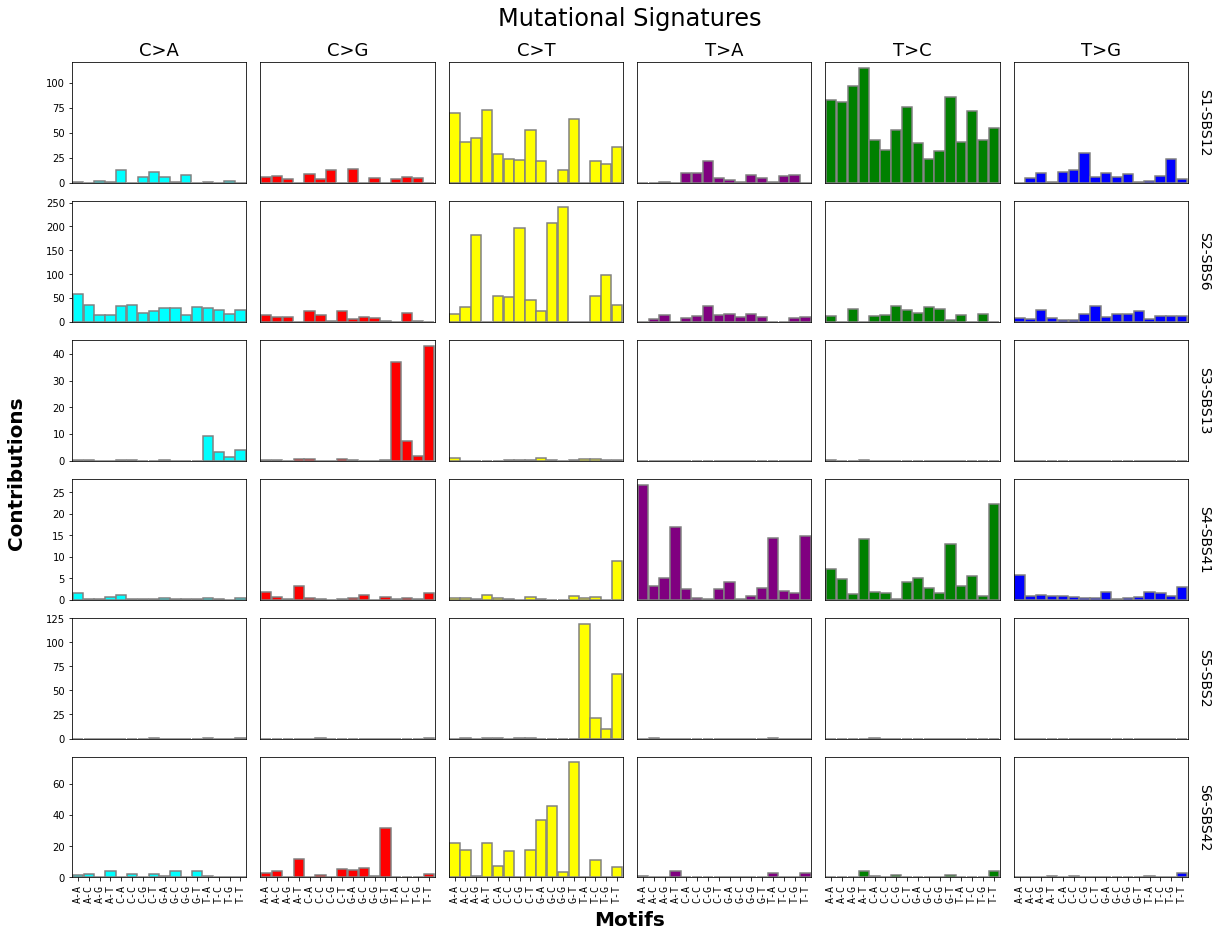

In [12]:
_ = sa.pl.signature_barplot(W, np.sum(H.iloc[:,:6]))